<h1>1. Setup and Load Data</h1>

<h2>1.1. Install Dependencies and Setup</h2>

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Avoid OOM error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>1.2. Load Data</h2>

In [3]:
data_dir = 'data/Train'
os.listdir(data_dir)

['fake', 'real']

In [4]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    class_names=['real', 'fake'],
    batch_size = 16,
    image_size=(100, 100)
)

Found 140002 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(16, 100, 100, 3)

In [6]:
batch[1]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1])

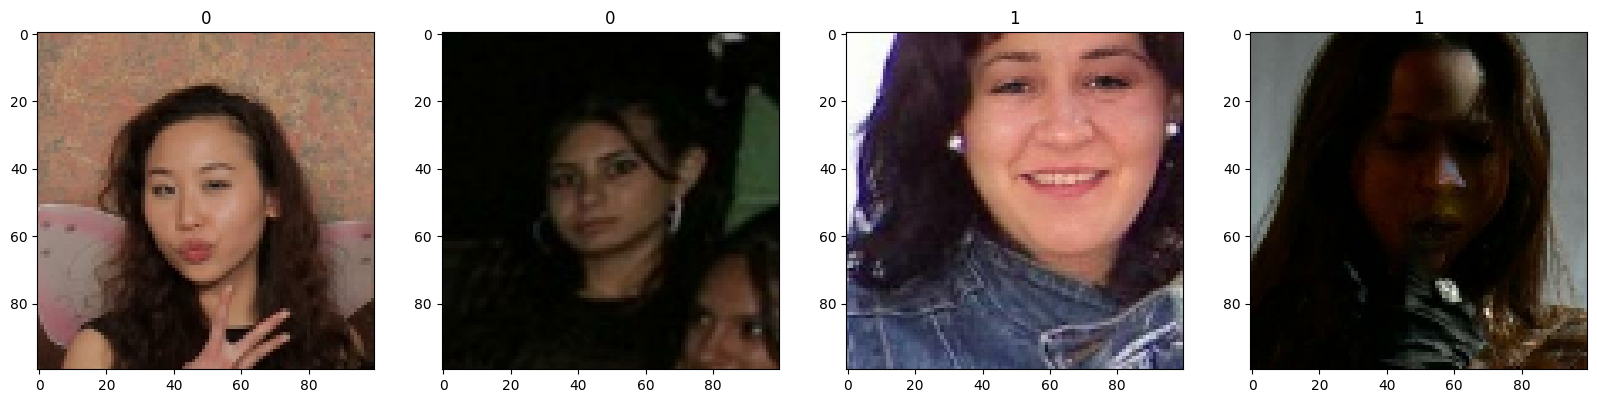

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h1>2. Preprocess the data</h1>

<h2>2.1. Scale Data</h2>

In [8]:
data = data.map(lambda x, y: (x / 255, y))

<h2>2.2. Split the Data</h2>

In [9]:
len(data)

8751

In [10]:
train_size = int(len(data)* .7)
val_size = int(len(data)* .2) 
test_size = int(len(data)* .1) + 1

In [11]:
(val_size + train_size + test_size) == len(data)

True

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

<h1>3. Deep Model</h1>

<h2>3.1. Build Deep Learning Model</h2>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [14]:
model = Sequential()

resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(100, 100, 3),
    pooling='avg'
)

for layer in resnet_model.layers[:-10]:
    layer.trainable = False

In [15]:
model.add(resnet_model)
model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

<h2>Train</h2>

In [18]:
logdir = 'logs'

if not os.path.exists(logdir):
    os.makedirs(logdir)

checkpoint_dir = 'training'
checkpoint_path = os.path.join(checkpoint_dir, 'cp.ckpt')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print('Loaded latest checkpoint:', latest_checkpoint)

Loaded latest checkpoint: training\cp.ckpt


In [21]:
hist = model.fit(train, epochs=45, initial_epoch=39, validation_data=val, callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 40/45
6125/6125 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9403
Epoch 40: saving model to training\cp.ckpt
6125/6125 [==============================] - 413s 66ms/step - loss: 0.1984 - accuracy: 0.9403 - val_loss: 0.1332 - val_accuracy: 0.9782
Epoch 41/45
6125/6125 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9442
Epoch 41: saving model to training\cp.ckpt
6125/6125 [==============================] - 713s 116ms/step - loss: 0.1854 - accuracy: 0.9442 - val_loss: 0.1970 - val_accuracy: 0.9379
Epoch 42/45
6125/6125 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9453
Epoch 42: saving model to training\cp.ckpt
6125/6125 [==============================] - 609s 99ms/step - loss: 0.1819 - accuracy: 0.9453 - val_loss: 0.1001 - val_accuracy: 0.9806
Epoch 43/45
6125/6125 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9462
Epoch 43: saving model to training\cp.ckpt
6125/6125 [============

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 878ms/step


In [34]:
print(f'Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision : 0.9608272910118103, Recall : 0.993907630443573, Accuracy : 0.9765033721923828


In [35]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'deepfake_detection_ResNet50V2_final_model.h5'))

In [36]:
model = load_model(os.path.join('models', 'deepfake_detection_ResNet50V2_Final_model.h5'))

In [28]:
import cv2

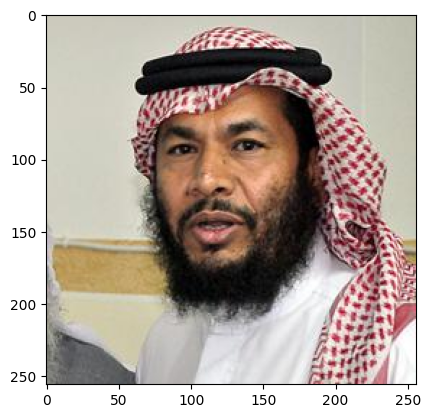

In [29]:
img = cv2.imread('real_0.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

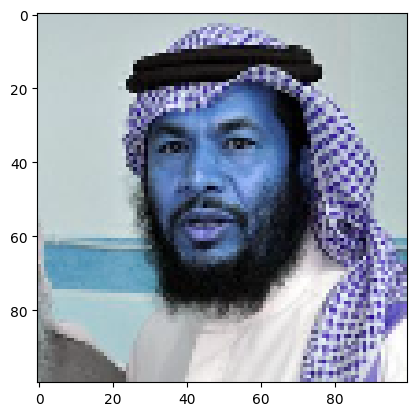

In [30]:
resize = tf.image.resize(img, (100, 100))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 2s 2s/step


In [32]:
if yhat < 0.5 :
    print('Predicted class is Real.')
else :
    print('Predicted class is Fake.')

Predicted class is Fake.


In [33]:
yhat

array([[0.9000242]], dtype=float32)